In [1]:
import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from MNIST_models.plotters import plot_trajectories, plot_images

from src.tools import load_dataset

import wandb

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
batch_size = 64
IMG_SIZE = 32
IMG_CHANNELS = 3
ZC = 1
Z_STD = 1.0
GAMMA = 1.0

TIME_DIM = 128
UNET_BASE_FACTOR = 48
N_STEPS = 10

lr = 1e-4

G_ITERS = 10
D_ITERS = 1
f_ITERS = 5
MAX_STEPS = 50000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
sampler3, test_sampler3 = load_dataset('MNIST-colored_3', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
sampler2, test_sampler2 = load_dataset('MNIST-colored_2', './datasets/MNIST', img_size=IMG_SIZE, batch_size=batch_size, device=device)
Y_sampler = sampler3
X_sampler = sampler2

In [5]:
from MNIST_models.cunet import CUNet
from MNIST_models.resnet import ResNet_D
from MNIST_models.unet import UNet
from MNIST_models.enot import SDE, G_wrapper

In [6]:
D = ResNet_D(IMG_SIZE, nc=IMG_CHANNELS).to(device)
G = UNet(IMG_CHANNELS+ZC, IMG_CHANNELS, base_factor=UNET_BASE_FACTOR).to(device)
G = G_wrapper(G, ZC, Z_STD)
f = CUNet(IMG_CHANNELS, IMG_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR).to(device)
sde = SDE(shift_model=f, n_steps=N_STEPS, time_dim=TIME_DIM).to(device)

sde_opt = Adam(sde.parameters(), lr=lr*10)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)


# D_checkpoint  = torch.load('D_checkpoint.pth')
# D.load_state_dict(D_checkpoint['D'])
# D_opt.load_state_dict(D_checkpoint['optimizer_D'])

# G_checkpoint  = torch.load('G_checkpoint.pth')
# G.load_state_dict(G_checkpoint['G'])
# G_opt.load_state_dict(G_checkpoint['optimizer_G'])

# sde_checkpoint  = torch.load('sde_checkpoint.pth')
# sde.load_state_dict(sde_checkpoint['sde'])
# sde_opt.load_state_dict(sde_checkpoint['optimizer_sde'])
    
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))
print('G params:', np.sum([np.prod(p.shape) for p in G.parameters()]))
print('sde params:', np.sum([np.prod(p.shape) for p in sde.parameters()]))

D params: 13494209
G params: 9716259
sde params: 9934611


In [7]:
def trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                xN = G(x0)
                
                t = (torch.rand(batch_size)*0.99).to(device)
                t_emb = sde.time(t)[:, :, None, None]
                t = t[:, None, None, None]
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((sde.shift_model(xt, t_emb) - (xN - xt)/(1-t)) ** 2).mean()
                sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()

            x0 = X_sampler.sample(batch_size)
            xN = G(x0)

            t = (torch.rand(batch_size)*0.99).to(device)
            t_emb = sde.time(t)[:, :, None, None]
            t = t[:, None, None, None]
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = sde.shift_model(xt, t_emb)
            E = (xN - xt)/(1-t)

            loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)*2
            loss2 = - D(xN).mean()
            # loss2 = 0

            G_loss = loss1 + loss2
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        
        # plotter 1
        if step % 10 == 1:
            clear_output(wait=True)
            
            plot_trajectories(sde, GAMMA, X_sampler, 3)
            plot_images(sde, X_sampler, 4, 4)
            plt.show()
            
    
        for D_iter in range(D_ITERS):
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            xN = G(x0)
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

        wandb.log({f'f_loss' : f_loss.item()}, step=step)
        wandb.log({f'G_loss' : G_loss.item()}, step=step)
        wandb.log({f'D_loss' : D_loss.item()}, step=step)

    return (G_mse, G_var, sde_mse, sde_var)

In [8]:
wandb.init(project='MNIST_EOT')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ilyasudakov (sudakov). Use `wandb login --relogin` to force relogin


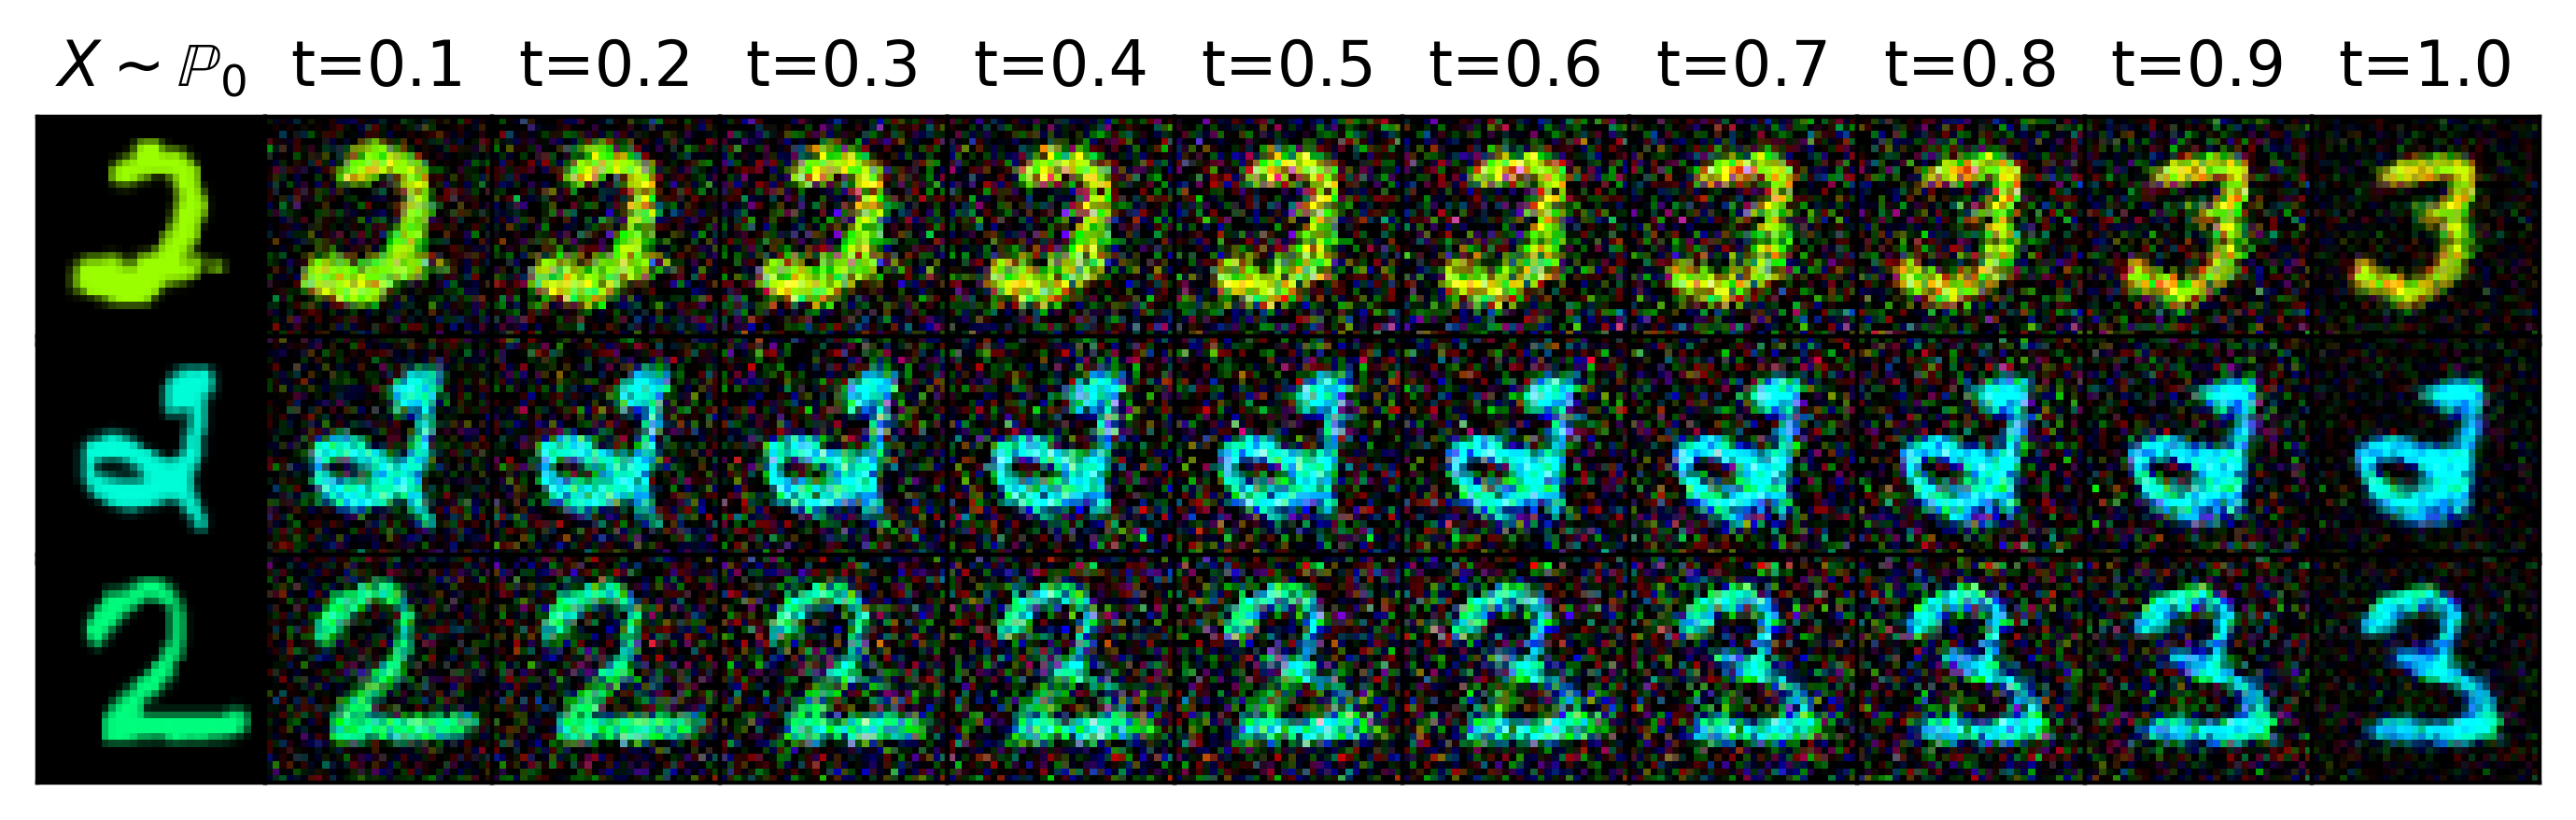

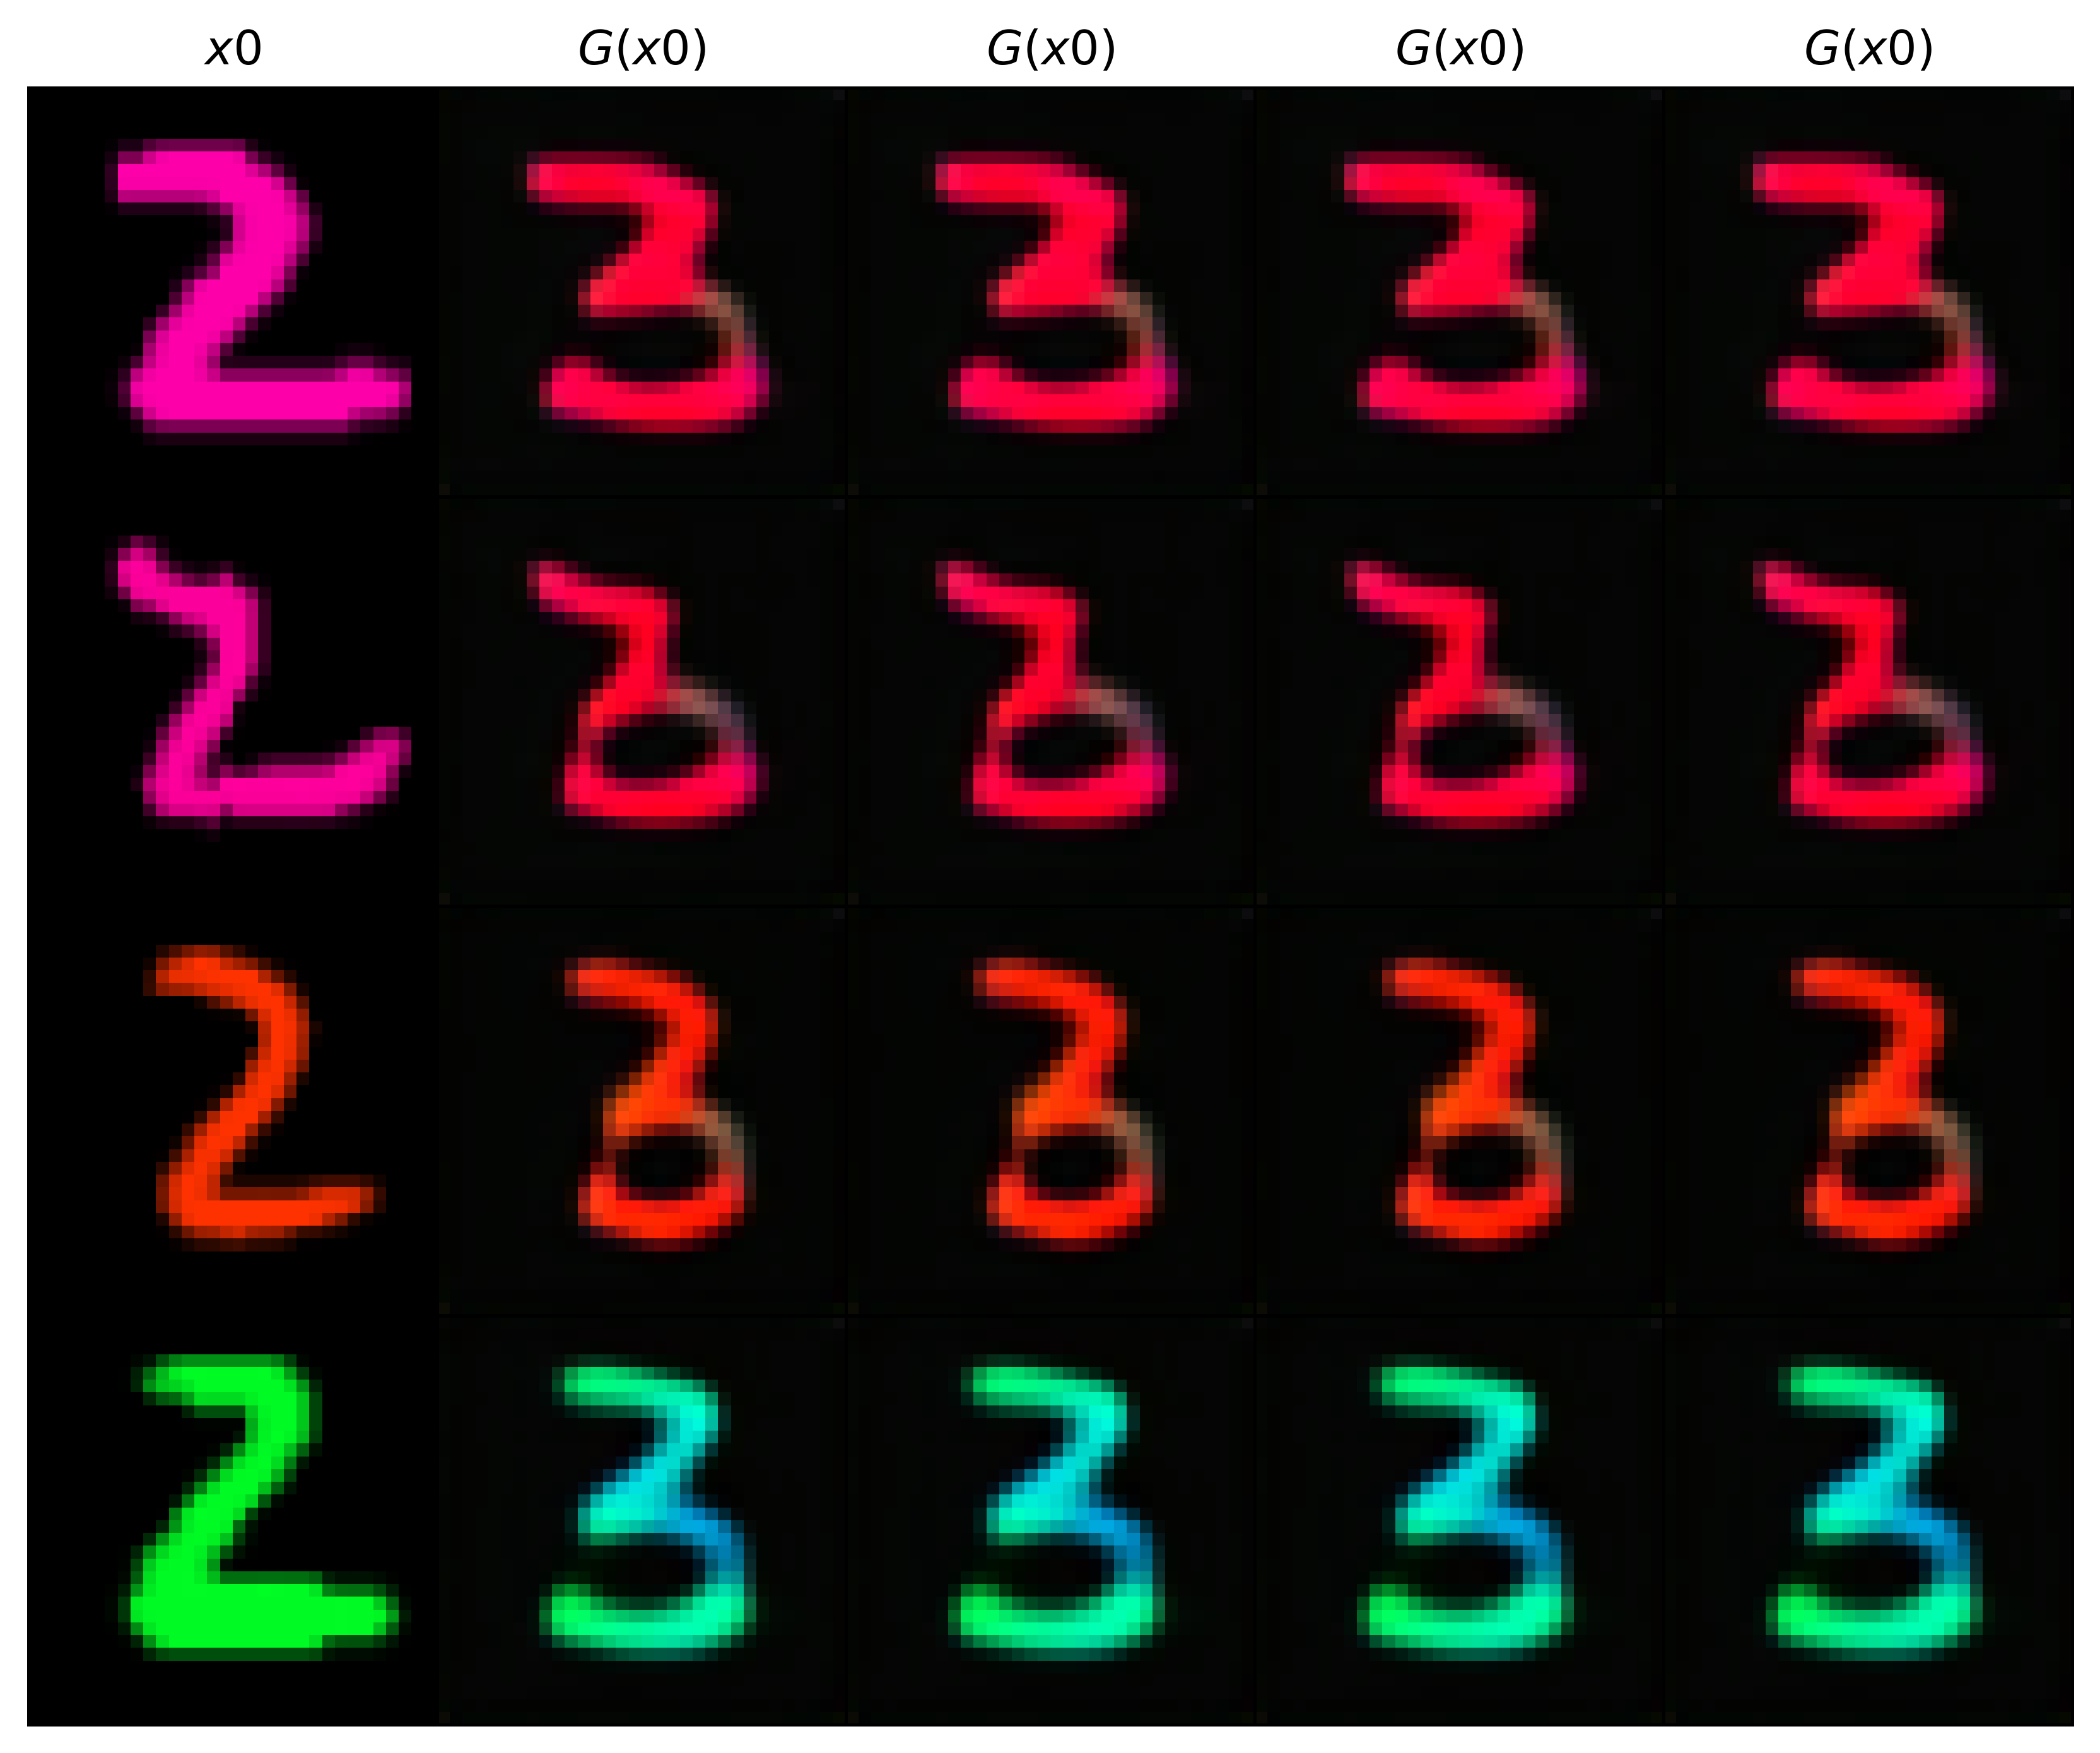

  6%|▌         | 3012/50000 [4:46:17<79:29:04,  6.09s/it]
Aborted!
  6%|▌         | 3012/50000 [4:46:17<74:26:19,  5.70s/it]


KeyboardInterrupt: 

In [9]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt)

In [ ]:
# D_checkpoint = { 
#     'D': D.state_dict(),
#     'optimizer_D': D_opt.state_dict()}
# torch.save(D_checkpoint, 'D_checkpoint.pth')

In [ ]:
# G_checkpoint = { 
#     'G': G.state_dict(),
#     'optimizer_G': G_opt.state_dict()}
# torch.save(G_checkpoint, 'G_checkpoint.pth')

In [ ]:
# sde_checkpoint = { 
#     'sde': sde.state_dict(),
#     'optimizer_sde': sde_opt.state_dict()}
# torch.save(sde_checkpoint, 'sde_checkpoint.pth')

In [ ]:
# D_checkpoint  = torch.load('D_checkpoint.pth')
# D.load_state_dict(D_checkpoint['D'])
# D_opt.load_state_dict(D_checkpoint['optimizer_D'])

# G_checkpoint  = torch.load('G_checkpoint.pth')
# G.load_state_dict(G_checkpoint['G'])
# G_opt.load_state_dict(G_checkpoint['optimizer_G'])

# sde_checkpoint  = torch.load('sde_checkpoint.pth')
# sde.load_state_dict(sde_checkpoint['sde'])
# sde_opt.load_state_dict(sde_checkpoint['optimizer_sde'])